# IRM Analysis
This notebook will compare the performance of IRM on an unseen platform's worth of gene expression to that of ERM. These results will be used for the preliminary data section for Aim 2 in my prelim proposal.

The EDA code is [here](#EDA), or to skip to the analysis, go [here](#eval)

<a id='eda'></a>
## Sepsis EDA

To have a good measure of training performance, ideally we'll have one platform's data held out as a validation set. To see how possible that is, we'll do exploratory data analysis on the sepsis studies in the dataset. 

In [1]:
import itertools
import json
import os
import sys

import pandas as pd
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import torch
from plotnine import *
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from whistl import datasets
from whistl.datasets import CompendiumDataset
from whistl import models
from whistl import train
from whistl import utils

In [2]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)

In [3]:
curr_path = os.path.dirname(os.path.abspath(os.path.abspath('')))

map_file = os.path.join(curr_path, os.pardir, 'data', 'sample_classifications.pkl')
sample_to_label = utils.parse_map_file(map_file)
sample_ids = sample_to_label.keys()

metadata_file = os.path.join(curr_path, os.pardir, 'data', 'all_metadata.json')
metadata_json = json.load(open(metadata_file))
sample_metadata = metadata_json['samples']

sample_ids = utils.filter_invalid_samples(sample_metadata, sample_ids)

sample_to_platform = utils.map_sample_to_platform(metadata_json, sample_ids)
sample_to_study = utils.map_sample_to_study(metadata_json, sample_ids)

In [4]:
compendium_path = os.path.join(curr_path, os.pardir, 'data', 'subset_compendium.tsv')

compendium_df = datasets.load_compendium_file(compendium_path)
compendium_df.head()

,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58HA300104,E-MEXP-1635-04SE59HA300104,E-MEXP-1635-04SE60HA300104,E-MEXP-1635-04SE61HA300104,E-MEXP-1635-04SE62HA300104,E-MEXP-1635-04SE63HA300104,E-MEXP-1635-04SE649HGU133A_201004,E-MEXP-1635-04SE64HA300104,E-MEXP-1635-04SE650HGU133A_201004,...,SRR6870393,SRR6870394,SRR6870395,SRR6870396,SRR6870397,SRR6870398,SRR6870399,SRR6870400,SRR6870401,SRR6870402
ENSG00000000003,0.208914,0.247681,0.133060,0.225220,0.225110,0.145763,0.203744,0.101624,0.216774,0.137222,...,0.244141,0.287628,0.234996,0.179500,0.262060,0.264090,0.248505,0.248617,0.231635,0.220124
ENSG00000000005,-0.060592,-0.057062,-0.015866,-0.076875,-0.011201,-0.055769,-0.060138,-0.000146,-0.039444,0.068918,...,-0.171151,-0.170181,-0.168437,-0.165942,-0.167972,-0.166330,-0.160954,-0.161027,-0.164263,-0.164568
ENSG00000000419,6.833205,9.714408,9.193253,10.588144,10.091911,9.000752,7.399193,7.174791,8.533220,9.249745,...,0.703249,0.713038,0.970236,1.070772,0.961582,1.051032,1.369086,1.264025,0.869870,0.743825
ENSG00000000457,0.214447,0.087237,0.402771,0.209681,0.141353,0.253218,0.188318,0.908775,0.174844,0.388580,...,2.497381,2.674494,2.394772,2.429598,2.450469,2.638023,2.240824,2.407291,1.933599,2.470088
ENSG00000000460,-0.057339,-0.034758,-0.043255,-0.078963,-0.096355,-0.098674,0.005090,0.037494,-0.033465,-0.112916,...,0.693359,0.464540,0.580630,0.692895,0.408506,0.515283,0.653895,0.437554,0.306867,0.569878


In [5]:
sepsis_samples = [sample for sample in sample_ids if sample_to_label[sample] == 'sepsis']
sepsis_platforms = [sample_to_platform[sample] for sample in sepsis_samples]
sepsis_studies = [sample_to_study[sample] for sample in sepsis_samples]
print(len(sepsis_samples))
print(len(sepsis_platforms))
print(len(sepsis_studies))

1319
1319
1319


In [6]:
sepsis_metadata_dict = {'sample': sepsis_samples, 'platform': sepsis_platforms, 'study': sepsis_studies}
sepsis_metadata_df = pd.DataFrame(sepsis_metadata_dict)
sepsis_metadata_df = sepsis_metadata_df.set_index('sample')
sepsis_metadata_df.head()

,platform,study
sample,,
GSM102985,affymetrix human genome u133 plus 2.0 array (h...,GSE4607
GSM102986,affymetrix human genome u133 plus 2.0 array (h...,GSE4607
GSM102987,affymetrix human genome u133 plus 2.0 array (h...,GSE4607
GSM102988,affymetrix human genome u133 plus 2.0 array (h...,GSE4607
GSM102989,affymetrix human genome u133 plus 2.0 array (h...,GSE4607


In [7]:
sepsis_metadata_df['platform'].value_counts()

affymetrix human genome u133 plus 2.0 array (hgu133plus2)    953
affymetrix human genome u133a 2.0 array (hgu133a2)            85
affymetrix human human exon 1.0 st array (huex10st)           74
affymetrix human gene 1.0 st array (hugene10st)               54
illumina hiseq 2500 (illuminahiseq2500)                       52
affymetrix human genome u219 array (hgu219)                   51
illumina genome analyzer iix (illuminagenomeanalyzeriix)      49
affymetrix human genome u133a array (hgu133a)                  1
Name: platform, dtype: int64

In [8]:
sepsis_metadata_df[sepsis_metadata_df['platform'] == 'affymetrix human genome u133a array (hgu133a)']

,platform,study
sample,,
GSM301847,affymetrix human genome u133a array (hgu133a),GSE11907


In [9]:
# Remove platform with only one sample to reduce downstream variance
sepsis_metadata_df = sepsis_metadata_df.drop(labels='GSM301847', axis=0)
print(len(sepsis_metadata_df.index))

1318


In [10]:
sepsis_metadata_df['study'].value_counts()

GSE66099     196
GSE13904     152
GSE95233     100
GSE26440      98
GSE26378      82
GSE57065      80
GSE74224      74
SRP132709     64
GSE66890      54
GSE4607       54
GSE33341      51
GSE8121       51
GSE65682      51
GSE9960       47
SRP049820     37
GSE10474      34
GSE33118      20
GSE33119      19
GSE11755      18
GSE64457      15
GSE25504      11
GSE28750      10
Name: study, dtype: int64

<a id='eval'></a>
## IRM Evaluation

### Setup
This code is unnecessary, as the variables are already initialized in the EDA section.
It is included here for the sake of clarity for people who skip to the analysis

In [11]:
curr_path = os.path.dirname(os.path.abspath(os.path.abspath('')))

map_file = os.path.join(curr_path, os.pardir, 'data', 'sample_classifications.pkl')
sample_to_label = utils.parse_map_file(map_file)

metadata_path = os.path.join(curr_path, os.pardir, 'data', 'all_metadata.json')

compendium_path = os.path.join(curr_path, os.pardir, 'data', 'subset_compendium.tsv')

### More setup
Initialize the model and encoder for the training process

In [12]:
classes = ['sepsis', 'healthy']
encoder = preprocessing.LabelEncoder()
encoder.fit(classes)

LabelEncoder()

### Tune split
We will get a rough estimate of performance with leave-one-out cross-validation. To know when to stop training, though, we will need a tuning dataset.

In [13]:
tune_df = sepsis_metadata_df[sepsis_metadata_df['platform'] == 'affymetrix human genome u219 array (hgu219)']
train_df = sepsis_metadata_df[sepsis_metadata_df['platform'] != 'affymetrix human genome u219 array (hgu219)']
print(len(tune_df.index))
print(len(train_df.index))

tune_studies = tune_df['study'].unique()
tune_dataset = CompendiumDataset(tune_studies, classes, sample_to_label, metadata_path, compendium_path, encoder)
tune_loader = DataLoader(tune_dataset, batch_size=1)

51
1267


### Filter Platforms
Remove a platform that corresponds to a study present in the labeled data, but not the human compendium

In [14]:
platforms = train_df['platform'].unique()
platforms = [p for p in platforms if p != 'affymetrix human human exon 1.0 st array (huex10st)']

### Train loop

In [15]:
irm_result_list = []
erm_result_list = []
num_seeds = 5

for hold_out_platform in platforms:
    train_platforms = train_df[train_df['platform'] != hold_out_platform]['platform'].unique()

    train_loaders = []
    total_irm_samples = 0
    for platform in train_platforms:
        studies = train_df[train_df['platform'] == platform]['study']
        train_dataset = CompendiumDataset([platform], classes, sample_to_label, metadata_path, compendium_path, 
                                          encoder, mode='platform')
        total_irm_samples += len(train_dataset)

        if len(train_dataset) > 0:
            train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
            train_loaders.append(train_loader)

    platform_file = hold_out_platform.split('(')[-1].strip(')')

    full_train_studies = train_df[train_df['platform'] != hold_out_platform]['study'].unique()
    full_train_dataset = CompendiumDataset(train_platforms, classes, sample_to_label, metadata_path,
                                           compendium_path, encoder, mode='platform')
    full_train_loader = DataLoader(full_train_dataset, batch_size=8, shuffle=True)

    assert total_irm_samples == len(full_train_dataset)
    
    for seed in range(num_seeds):
        print(hold_out_platform, seed)
        np.random.seed(seed)
        random.seed(seed)
        net = models.ThreeLayerNet(len(compendium_df.index))
        writer = SummaryWriter(os.path.join(curr_path, 
                                            os.pardir, 
                                            'logs', 
                                            'erm_analysis_{}_{}.tfrecord'.format(platform_file, seed)))

        save_file = os.path.join(curr_path, os.pardir, 'logs', 'erm_analysis_{}_{}.pkl'.format(platform_file, seed))
        results = train.train_with_erm(net, full_train_loader, tune_loader, num_epochs=400, 
                                       save_file=save_file, writer=writer)
        erm_result_list.append(results)

        net = models.ThreeLayerNet(len(compendium_df.index))
        writer = SummaryWriter(os.path.join(curr_path, os.pardir, 'logs', 
                                            'irm_analysis_{}_{}.tfrecord'.format(platform_file, seed)))

        save_file = os.path.join(curr_path, os.pardir, 'logs', 'irm_analysis_{}_{}.pkl'.format(platform_file, seed))
        results = train.train_with_irm(net, train_loaders, tune_loader, num_epochs=400, 
                                       loss_scaling_factor=1, save_file=save_file, writer=writer, burn_in_epochs=0)
        irm_result_list.append(results)


affymetrix human genome u133 plus 2.0 array (hgu133plus2) 0



affymetrix human genome u133 plus 2.0 array (hgu133plus2) 1



affymetrix human genome u133 plus 2.0 array (hgu133plus2) 2



affymetrix human genome u133 plus 2.0 array (hgu133plus2) 3



affymetrix human genome u133 plus 2.0 array (hgu133plus2) 4



affymetrix human gene 1.0 st array (hugene10st) 0



affymetrix human gene 1.0 st array (hugene10st) 1



affymetrix human gene 1.0 st array (hugene10st) 2



affymetrix human gene 1.0 st array (hugene10st) 3



affymetrix human gene 1.0 st array (hugene10st) 4



affymetrix human genome u133a 2.0 array (hgu133a2) 0



affymetrix human genome u133a 2.0 array (hgu133a2) 1



affymetrix human genome u133a 2.0 array (hgu133a2) 2



affymetrix human genome u133a 2.0 array (hgu133a2) 3



affymetrix human genome u133a 2.0 array (hgu133a2) 4



illumina genome analyzer iix (illuminagenomeanalyzeriix) 0



illumina genome analyzer iix (illuminagenomeanalyzeriix) 1



illumina genome analyzer iix (illuminagenomeanalyzeriix) 2



illumina genome analyzer iix (illuminagenomeanalyzeriix) 3



illumina genome analyzer iix (illuminagenomeanalyzeriix) 4



illumina hiseq 2500 (illuminahiseq2500) 0



illumina hiseq 2500 (illuminahiseq2500) 1



illumina hiseq 2500 (illuminahiseq2500) 2



illumina hiseq 2500 (illuminahiseq2500) 3



illumina hiseq 2500 (illuminahiseq2500) 4


In [16]:
def eval_model(net, loader):
    all_labels = []
    all_preds = []
    for batch in loader:
        expression, labels, ids = batch
        expression = expression.float().to('cuda')
        labels = labels.numpy()
        all_labels.extend(labels)
                
        output = net(expression)
        preds = [1 if p > 0 else 0 for p in output]
        all_preds.extend(preds)
        
    f1 = metrics.f1_score(all_labels, all_preds)
        
    return f1
        

In [17]:
irm_f1_scores = []
erm_f1_scores = []
for hold_out_platform in platforms:
    for seed in range(num_seeds):
        # Load data
        try:
            hold_out_studies = train_df[train_df['platform'] == hold_out_platform]['study']
            hold_out_dataset = CompendiumDataset(hold_out_studies, classes, sample_to_label, metadata_path, compendium_path, encoder)
            hold_out_loader = DataLoader(hold_out_dataset, batch_size=1, shuffle=False)

            # Load IRM model
            platform_file = hold_out_platform.split('(')[-1].strip(')')
            save_file = os.path.join(curr_path, os.pardir, 'logs', 'irm_analysis_{}_{}.pkl'.format(platform_file, seed))
            net = torch.load(save_file, 'cuda')

            #Evaluate ERM model
            f1_score = eval_model(net, hold_out_loader)
            irm_f1_scores.append(f1_score)

            # Load ERM model
            save_file = os.path.join(curr_path, os.pardir, 'logs', 'erm_analysis_{}_{}.pkl'.format(platform_file, seed))
            net = torch.load(save_file, 'cuda')

            # Evaluate IRM model
            f1_score = eval_model(net, hold_out_loader)
            erm_f1_scores.append(f1_score)
        except FileNotFoundError as e:
            print(e)

In [18]:
print(irm_f1_scores)
print(erm_f1_scores)
held_out_platform_list = []
for platform in platforms:
    p = [platform] * 2 * num_seeds
    held_out_platform_list.extend(p)
#print(held_out_platform_list)

score_list = list(itertools.chain(*zip(irm_f1_scores, erm_f1_scores)))
print(score_list)
label_list = (['irm'] + ['erm']) *  (len(score_list) // 2)
print(label_list)

[0.9439912996193585, 0.8746355685131194, 0.9339933993399339, 0.8856812933025404, 0.8627218934911243, 0.8260869565217391, 0.7586206896551725, 0.7727272727272727, 0.851063829787234, 0.8387096774193548, 0.671875, 0.7218045112781954, 0.4684684684684685, 0.9032258064516129, 0.7313432835820896, 0.9166666666666666, 0.8496732026143792, 0.8888888888888888, 0.9024390243902439, 0.9156626506024096, 0.9841269841269841, 0.9841269841269841, 0.959349593495935, 0.9921259842519685, 0.976]
[0.9427792915531334, 0.9542272482498655, 0.9565683646112602, 0.8939828080229225, 0.9427792915531334, 0.8865979381443299, 0.6987951807228916, 0.7865168539325843, 0.8631578947368421, 0.8750000000000001, 0.9171974522292993, 0.8590604026845637, 0.8666666666666666, 0.8590604026845637, 0.888888888888889, 0.8516129032258064, 0.9080459770114941, 0.8734177215189873, 0.8957055214723927, 0.9122807017543859, 1.0, 0.9841269841269841, 0.976, 0.959349593495935, 0.9921259842519685]
[0.9439912996193585, 0.9427792915531334, 0.8746355685

In [19]:
result_dict = {'f1_score': score_list, 'irm/erm': label_list, 'held_out_platform': held_out_platform_list}
result_df = pd.DataFrame(result_dict)
result_df.head()

,f1_score,irm/erm,held_out_platform
0,0.943991,irm,affymetrix human genome u133 plus 2.0 array (h...
1,0.942779,erm,affymetrix human genome u133 plus 2.0 array (h...
2,0.874636,irm,affymetrix human genome u133 plus 2.0 array (h...
3,0.954227,erm,affymetrix human genome u133 plus 2.0 array (h...
4,0.933993,irm,affymetrix human genome u133 plus 2.0 array (h...


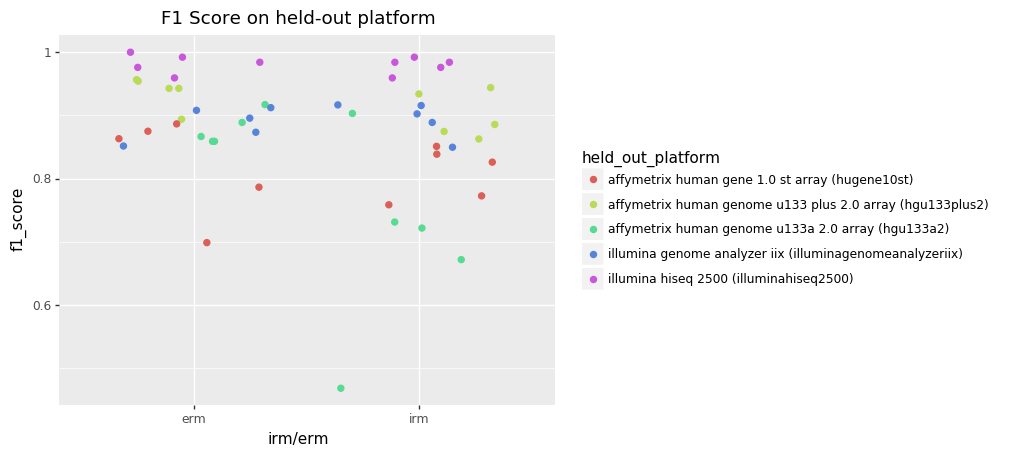

<ggplot: (8736898778461)>

In [20]:
(ggplot(result_df, aes('irm/erm', 'f1_score', color='held_out_platform')) +
 geom_jitter(size=2) +
 ggtitle('F1 Score on held-out platform')
)

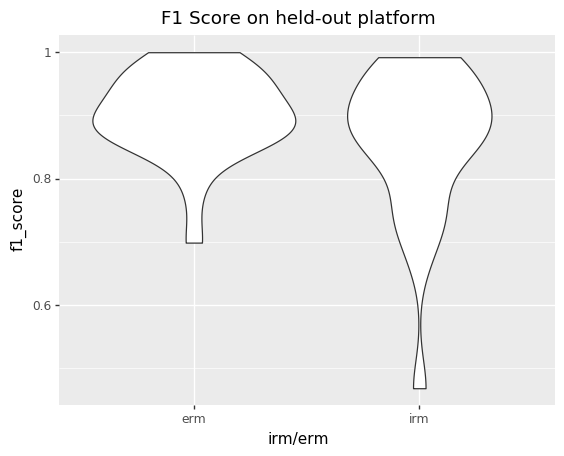

<ggplot: (8736893716077)>

In [21]:
(ggplot(result_df, aes('irm/erm', 'f1_score')) +
 geom_violin() +
 ggtitle('F1 Score on held-out platform')
)

In [22]:
irm_accs = [result['tune_acc'] for result in irm_result_list]
irm_mean_accs = [sum(accs) / len(accs) for accs in irm_accs]
print(irm_mean_accs)
[acc.sort() for acc in irm_accs]
irm_median_accs = [acc[len(acc) //2] for acc in irm_accs]
print(irm_median_accs)

[0.7832526881720417, 0.7790860215053754, 0.9122580645161297, 0.7412365591397829, 0.8444354838709668, 0.9330376344086022, 0.8984408602150556, 0.9170967741935497, 0.8836559139784947, 0.8678225806451623, 0.9334139784946238, 0.9541129032258082, 0.9343817204301073, 0.9828225806451613, 0.9633064516129037, 0.9524731182795709, 0.8815591397849459, 0.9143279569892471, 0.9085752688172054, 0.9292204301075284, 0.9440322580645173, 0.8438440860215067, 0.9614247311827966, 0.9406182795698922, 0.95766129032258]
[0.7849462365591398, 0.7956989247311828, 0.9139784946236559, 0.7526881720430108, 0.8279569892473119, 0.946236559139785, 0.9354838709677419, 0.946236559139785, 0.9247311827956989, 0.9139784946236559, 0.956989247311828, 0.989247311827957, 0.978494623655914, 1.0, 0.989247311827957, 0.978494623655914, 0.9032258064516129, 0.946236559139785, 0.946236559139785, 0.967741935483871, 0.978494623655914, 0.8817204301075269, 0.978494623655914, 0.967741935483871, 0.989247311827957]


In [23]:
erm_accs = [result['tune_acc'] for result in erm_result_list]
erm_mean_accs = [sum(accs) / len(accs) for accs in erm_accs]
print(erm_mean_accs)
[acc.sort() for acc in erm_accs]
erm_median_accs = [acc[len(acc) //2] for acc in erm_accs]
print(erm_median_accs)

[0.8013709677419318, 0.8346774193548331, 0.7689247311827951, 0.8285483870967661, 0.8372311827956969, 0.9565053763440814, 0.8941666666666657, 0.9186827956989265, 0.9473655913978455, 0.9595161290322519, 0.9531182795698918, 0.9658602150537614, 0.9492204301075243, 0.9552419354838674, 0.9524999999999944, 0.939086021505376, 0.8954569892473104, 0.9637096774193478, 0.9575268817204217, 0.9458333333333345, 0.9161827956989218, 0.9554301075268756, 0.9133064516129036, 0.9212903225806446, 0.9204569892473089]
[0.8172043010752689, 0.8279569892473119, 0.7741935483870968, 0.8279569892473119, 0.8387096774193549, 0.956989247311828, 0.9032258064516129, 0.9139784946236559, 0.956989247311828, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.956989247311828, 0.967741935483871, 0.967741935483871, 0.946236559139785, 0.8924731182795699, 0.967741935483871, 0.967741935483871, 0.946236559139785, 0.9247311827956989, 0.967741935483871, 0.9139784946236559, 0.9247311827956989, 0.9354838709677419]


In [24]:
mean_list = list(itertools.chain(*zip(irm_mean_accs, erm_mean_accs)))
median_list = list(itertools.chain(*zip(irm_median_accs, erm_median_accs)))
label_list = (['irm'] + ['erm']) *  (len(mean_list) // 2)

held_out_platform_list = []
for platform in platforms:
    p = [platform] * 2 * num_seeds
    held_out_platform_list.extend(p)

result_dict = {'mean_acc': mean_list, 'median_acc': median_list, 'irm/erm': label_list, 
               'held_out_platform': held_out_platform_list}
result_df = pd.DataFrame(result_dict)

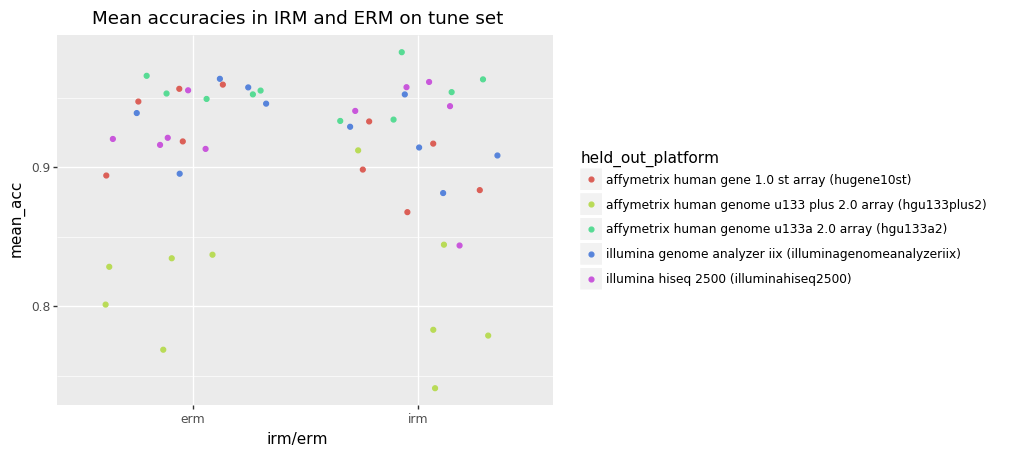

<ggplot: (8736886646957)>

In [25]:
(ggplot(result_df, aes('irm/erm', 'mean_acc', color='held_out_platform')) + 
 geom_jitter() +
 ggtitle('Mean accuracies in IRM and ERM on tune set')
)

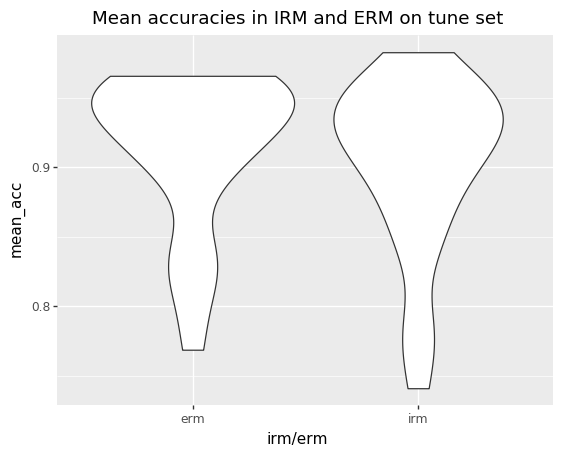

<ggplot: (8736888759465)>

In [26]:
(ggplot(result_df, aes('irm/erm', 'mean_acc')) + 
 geom_violin() +
 ggtitle('Mean accuracies in IRM and ERM on tune set')
)

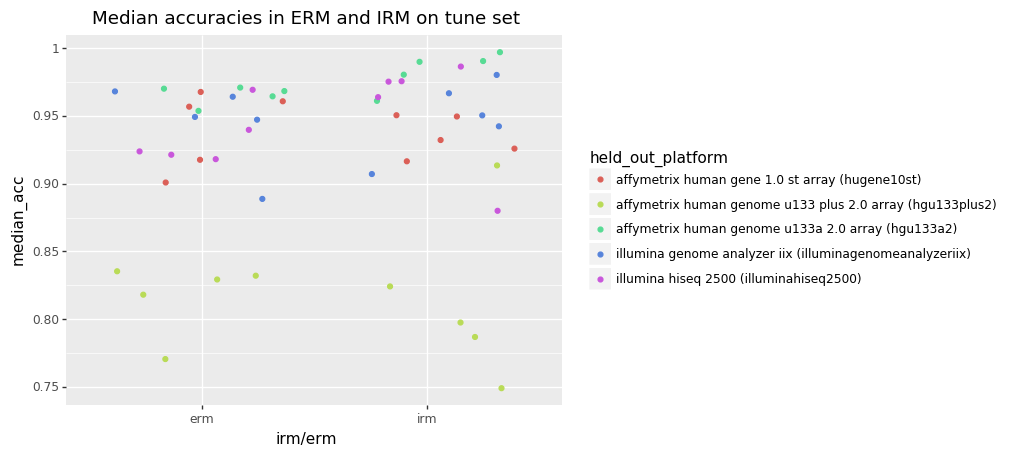

<ggplot: (8736888759341)>

In [27]:
(ggplot(result_df, aes('irm/erm', 'median_acc', color='held_out_platform')) + 
geom_jitter() +
ggtitle('Median accuracies in ERM and IRM on tune set')
)

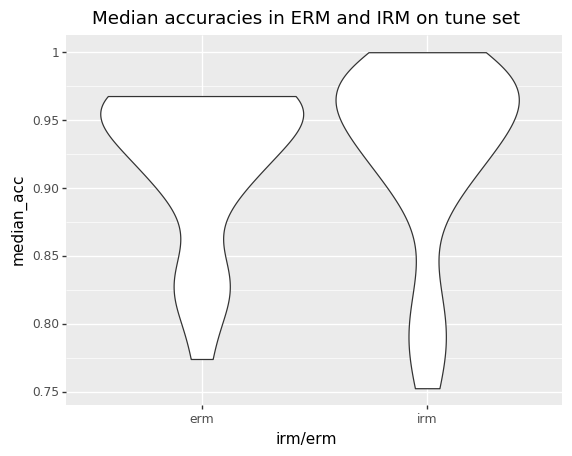

<ggplot: (8736888759481)>

In [28]:
(ggplot(result_df, aes('irm/erm', 'median_acc')) + 
geom_violin() +
ggtitle('Median accuracies in ERM and IRM on tune set')
)